In [1]:
using DataFrames
using CSV
using Gadfly
using GLM
using Optim
using Polynomials
using Statistics

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/berserker/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


##### Logistic Regression

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions decision. Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams. (ex2.pdf, page 2)

In [2]:
# load data into dataframe
file_url = "./machine-learning-ex2/ex2/ex2data1.txt"
data = CSV.read(file_url, datarow = 1)
describe(data, :eltype)

,variable,eltype
,Symbol,DataType
1,Column1,Float64
2,Column2,Float64
3,Column3,Int64


In [3]:
rename!(data, :Column1 => :exam1, :Column2 => :exam2, :Column3 => :admit);
first(data, 5)

,exam1,exam2,admit
,Float64⍰,Float64⍰,Int64⍰
1,34.6237,78.0247,0
2,30.2867,43.895,0
3,35.8474,72.9022,0
4,60.1826,86.3086,1
5,79.0327,75.3444,1


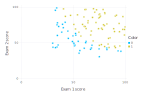

In [4]:
# plot exam scores against each other. 
# Whether a student was admitted or not is shown in different colors.

decision = categorical(data[:admit])
plot(data, x = :exam1, y = :exam2, color = decision,
    Geom.point,
    Guide.xlabel("Exam 1 score"),
    Guide.ylabel("Exam 2 score")
)

In [5]:
# compute sigmoid function
function sigmoidx(x)
    # input: scalar, vector or matrix of values
    # ouput: value(s) returned by sigmoid function
    1 ./(1 .+ map(exp, -x))
end

sigmoidx (generic function with 1 method)

In [6]:
# Test sigmoid function
sigmoidx(0), sigmoidx(-1e5), sigmoidx(1e10)

(0.5, 0.0, 1.0)

In [7]:
# returns a tuple with a matrix of features with ones added and the target vector
function designmat(df)
    # input: dataframe with features (end - 1) and outcome (end)
    # output:
            # matrix X: constant + feature vectors (dim = examples * features)
            # vector y: outcome (dim = examples * 1)
    X = hcat(ones(size(df[1])), convert(Matrix, df))[:,1:end-1]
    y = df[:,end]
    #return X, y
    return convert(Array{Float64, 2}, X), convert(Array{Float64, 1}, y)
end

designmat (generic function with 1 method)

In [8]:
# returns pointers to two functions: cost and grid
function costFunction(datamat, outcome)
    return (thetavals::Array) -> begin
                thetaX = thetavals'datamat'
                pos = -map(log, sigmoidx(thetaX)) * outcome
                neg = map(log, (1 .- sigmoidx(thetaX))) * (1 .- outcome)
                cost_θ = (pos - neg)/length(target)
                first(cost_θ) 
        end, (thetavals::Array) -> begin 
                thetaX = thetavals'datamat'
                partials = (datamat' * (sigmoidx(thetaX)' - outcome))/length(outcome)
                partials
        end
end

costFunction (generic function with 1 method)

In [9]:
features, target = designmat(data)
cost, grad = costFunction(features, target);

In [10]:
θ_initial = zeros(Float64, 3)
println("Cost at initial θ (zeros) is $(round(cost(θ_initial); digits = 3))")
println("Gradient at initial θ (zeros) is $(grad(θ_initial))")

Cost at initial θ (zeros) is 0.693
Gradient at initial θ (zeros) is [-0.1; -12.0092; -11.2628]


In [11]:
test_θ = [-24, 0.2, 0.2]
println("Cost at test θ (non-zero) is $(round(cost(test_θ); digits = 3))")
println("Gradient at test θ (non-zeros) is $(grad(test_θ))")

Cost at test θ (non-zero) is 0.218
Gradient at test θ (non-zeros) is [0.042903; 2.56623; 2.6468]


In [12]:
# use built-in optimizer 
res = optimize(cost, grad, θ_initial; inplace = false)

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-25.161333563346155,0.2062317132637093, ...]
 * Minimum: 2.034977e-01
 * Iterations: 16
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 2.35e-06 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 2.47e-14 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 8.58e-10 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 58
 * Gradient Calls: 58

In [13]:
println("Cost at θ found by optimizer: $(round(Optim.minimum(res), digits = 3))")
println("θs: $(Optim.minimizer(res))")

Cost at θ found by optimizer: 0.203
θs: [-25.1613, 0.206232, 0.201472]


In [14]:
# compare with coefficients from GLM function from GLM library
glm(@formula(admit ~ exam1 + exam2), data, Binomial(), LogitLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: admit ~ 1 + exam1 + exam2

Coefficients:
──────────────────────────────────────────────────────
               Estimate  Std.Error   z value  Pr(>|z|)
──────────────────────────────────────────────────────
(Intercept)  -25.1613    5.79836    -4.33939     <1e-4
exam1          0.206232  0.0479991   4.29657     <1e-4
exam2          0.201472  0.0486235   4.14351     <1e-4
──────────────────────────────────────────────────────

##### Predict probability for a student with score 45 on exam 1 and score 85 on exam 2 

In [15]:
test_data = [1.0 45.0 85.0]
pr_prob = sigmoidx(test_data * Optim.minimizer(res))
println("For a student with scores 45 and 85, we predict an admission probability of $(round(first(pr_prob), digits =  3))")

For a student with scores 45 and 85, we predict an admission probability of 0.776


In [16]:
# returns a vector of predictions given a vector of θs (admitted = 1, not admitted = 0)
function predictx(datamat, thetavals)
    xβ = thetavals'* datamat'
    pred_probs = sigmoidx(xβ)
    admitted = (pred_probs .>= 0.5) * 1
    return admitted'
end

predictx (generic function with 1 method)

In [17]:
# Compute accuracy on our training set
pred_admit = predictx(features, Optim.minimizer(res))
train_acc = mean(pred_admit .== target)
println("Train accuracy = $(train_acc * 100)%")

Train accuracy = 89.0%


##### Regularized Logistic Regression

Implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

In [18]:
# load data into dataframe and show first five rows
file_url = "./machine-learning-ex2/ex2/ex2data2.txt"
data = CSV.read(file_url, datarow = 1)
describe(data, :eltype)
rename!(data, :Column1 => :test1, :Column2 => :test2, :Column3 => :accept)
first(data, 5)

,test1,test2,accept
,Float64⍰,Float64⍰,Int64⍰
1,0.051267,0.69956,1
2,-0.092742,0.68494,1
3,-0.21371,0.69225,1
4,-0.375,0.50219,1
5,-0.51325,0.46564,1


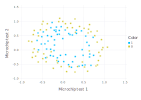

In [19]:
# Plot test 1 against test 2. Axes are the two test scores; and the positive (y = 1, accepted) 
# and negative (y = 0, rejected) examples are shown in different colors.

decision = categorical(data[:accept])
plot(data, x = :test1, y = :test2, color = decision,
    Geom.point,
    Guide.xlabel("Microchip test 1"),
    Guide.ylabel("Microchip test 2")
)

Above figure shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straightforward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

In [20]:
# feature mapping. Map the features into all polynomial terms of x1 and x2 up to the sixth power
# transforms vector of two features into a 28-dimensional vector.
function mapfeature(X1, X2)::Array
    degree = 6;
    out = ones(length(X1))
        for i = 1:degree
            for j = 0:i
                out = hcat(out, (X1.^(i-j)).*(X2.^j))
            end
        end
    out
end

mapfeature (generic function with 1 method)

In [21]:
# convert data to matrices
xmat = convert(Matrix, data)
ymat = data[:accept]
polymat = mapfeature(xmat[:,1], xmat[:,2]); # map features to polynomial terms
size(polymat)

(118, 28)

In [22]:
polymat[1:5, 1:10]

5×10 Array{Float64,2}:
 1.0   0.051267  0.69956  0.00262831  …  0.00183866   0.0250893  0.342354
 1.0  -0.092742  0.68494  0.00860108     0.00589122  -0.0435092  0.321335
 1.0  -0.21371   0.69225  0.045672       0.0316164   -0.102412   0.331733
 1.0  -0.375     0.50219  0.140625       0.0706205   -0.094573   0.12665 
 1.0  -0.51325   0.46564  0.263426       0.122661    -0.111283   0.10096 

In [23]:
# function return pointers to cost and gradient. 
# θ₀ (index = 1) is not regularized
function costFunction(datamat, outcome, λ)
    nobs = length(outcome)

    thetavals::Array -> begin        
            thetaX = thetavals'datamat'
            pos = -map(log, sigmoidx(thetaX)) * outcome
            neg = map(log, (1 .- sigmoidx(thetaX))) * (1 .- outcome)
            cost_θ = (pos - neg)/nobs
            penalty_θ = (λ/(2 * nobs)) * (thetavals[2:end]'thetavals[2:end]) 
            return first(cost_θ) + penalty_θ
        end, thetavals::Array -> begin
            nobs = length(outcome)
            thetaX = thetavals'datamat'
            partials = (datamat' * (sigmoidx(thetaX)' - outcome))/nobs
            penalty_θ = vcat(0, (λ/nobs) * thetavals[2:end])
            return partials + penalty_θ 
    end
end

costFunction (generic function with 2 methods)

In [24]:
thetas = zeros(size(polymat)[2])
lambda = 1
cost, grad = costFunction(polymat, ymat, lambda);
println("Cost at initial θ (zeros): $(round(cost(thetas), digits = 3))")
println("Gradient at initial θ (zeros) - first five values only: $(grad(thetas)[1:5])")

Cost at initial θ (zeros): 0.693
Gradient at initial θ (zeros) - first five values only: [0.00847458, 0.0187881, 7.77712e-5, 0.0503446, 0.0115013]


In [25]:
# Compute and display cost and gradient with all-ones theta and lambda = 10
test_thetas = ones(size(polymat)[2])
lambda = 10
cost, grad = costFunction(polymat, ymat, lambda);

println("Cost at test θ (ones): $(round(cost(test_thetas), digits = 3))")
println("Gradient at test θ (ones) - first five values only: $(grad(test_thetas)[1:5])")

Cost at test θ (ones): 3.165
Gradient at test θ (ones) - first five values only: [0.346045, 0.161352, 0.194796, 0.226863, 0.0921857]


In [26]:
# use built-in optimizer with initial θ (zeros) and λ = 1
θ_initial = zeros(size(polymat)[2])
lambda = 1
cost, grad = costFunction(polymat, ymat, lambda);
res = optimize(cost, grad, θ_initial; inplace = false)

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.0,0.0, ...]
 * Minimizer: [1.2727395883131525,0.6252716685333257, ...]
 * Minimum: 5.290027e-01
 * Iterations: 17
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 3.33e-06 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 3.16e-13 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 9.27e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 53
 * Gradient Calls: 53

In [27]:
println("Cost at θ found by optimizer: $(round(Optim.minimum(res), digits = 3))")
println("θs: $(Optim.minimizer(res))")

Cost at θ found by optimizer: 0.529
θs: [1.27274, 0.625272, 1.18109, -2.01996, -0.917424, -1.43166, 0.124006, -0.365534, -0.357239, -0.17513, -1.45816, -0.050989, -0.615555, -0.274706, -1.19282, -0.242188, -0.206006, -0.0447307, -0.277785, -0.295378, -0.456357, -1.0432, 0.0277718, -0.292431, 0.0155668, -0.32738, -0.143887, -0.924653]


In [28]:
# try out different regularization parameters for the dataset
θ_initial = zeros(size(polymat)[2])
lambdas = [0.000055, 1, 10, 100]

for lambda in lambdas
    cost, grad = costFunction(polymat, ymat, lambda);
    res = optimize(cost, grad, θ_initial; inplace = false)
    println("Cost (λ = $lambda): $(round(Optim.minimum(res), digits = 3))")
    pred_accept = predictx(polymat, Optim.minimizer(res))
    train_acc = mean(pred_accept .== ymat)
    println("Train accuracy = $(round(train_acc * 100, digits = 3))%")
end

Cost (λ = 5.5e-5): 0.282
Train accuracy = 86.441%
Cost (λ = 1.0): 0.529
Train accuracy = 83.051%
Cost (λ = 10.0): 0.648
Train accuracy = 74.576%
Cost (λ = 100.0): 0.686
Train accuracy = 61.017%
